In [5]:
# Step 1: Dataset Selection and Preparation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout




In [6]:
# Load dataset
data = pd.read_csv("data.csv",encoding='ISO-8859-1')
print(data.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  


In [7]:
# Handle missing values
data = data.dropna(subset=['CustomerID'])  # Drop rows with missing CustomerID

# Handle outliers
data = data[data['UnitPrice'] > 0]

# Create a "TotalPrice" feature
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

# Save cleaned data for further steps
data.to_csv("cleaned_online_retail.csv", index=False)


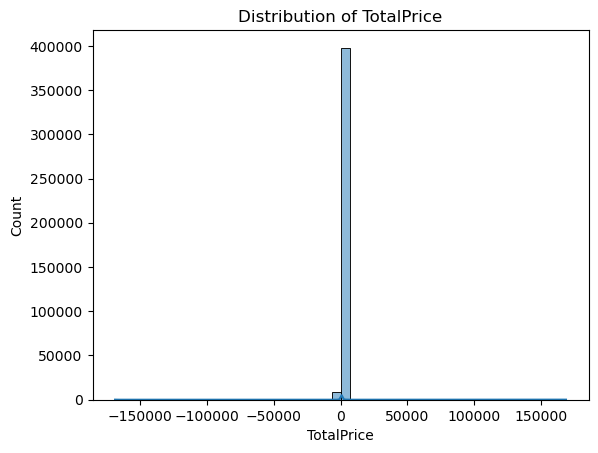

C:\Users\Ahmed\AppData\Local\Temp\ipykernel_28636\2978068806.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = data.corr()


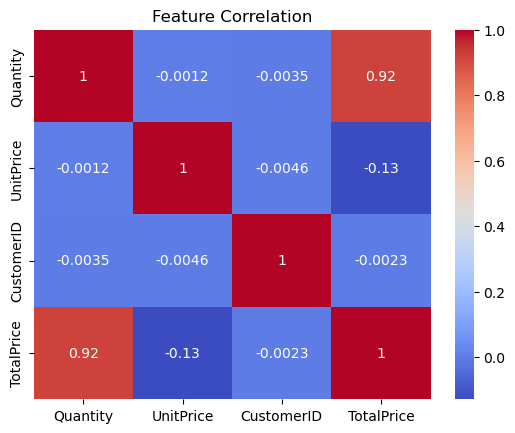

In [8]:
# Distribution of TotalPrice
sns.histplot(data['TotalPrice'], bins=50, kde=True)
plt.title("Distribution of TotalPrice")
plt.show()

# Correlation matrix
correlation = data.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()


In [9]:
# Extract month and day of purchase
data['InvoiceMonth'] = pd.to_datetime(data['InvoiceDate']).dt.month
data['InvoiceDay'] = pd.to_datetime(data['InvoiceDate']).dt.day

# Aggregating data by customer
customer_data = data.groupby('CustomerID').agg({
    'TotalPrice': 'sum',
    'Quantity': 'sum',
    'InvoiceMonth': 'nunique',
    'InvoiceDay': 'nunique'
}).reset_index()

customer_data.rename(columns={
    'TotalPrice': 'TotalSpent',
    'Quantity': 'TotalQuantity',
    'InvoiceMonth': 'ActiveMonths',
    'InvoiceDay': 'ActiveDays'
}, inplace=True)

print(customer_data.head())



   CustomerID  TotalSpent  TotalQuantity  ActiveMonths  ActiveDays
0     12346.0        0.00              0             1           1
1     12347.0     4310.00           2458             6           5
2     12348.0     1797.24           2341             4           3
3     12349.0     1757.55            631             1           1
4     12350.0      334.40            197             1           1


In [10]:
# Split features and labels
X = customer_data.drop(columns=['CustomerID'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [11]:
# Build the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_scaled.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # Assuming 3 market segments
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               640       
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 3)                 99        
                                                                 
Total params: 11075 (43.26 KB)
Trainable params: 11075 (43.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
# Create dummy labels for unsupervised segmentation (e.g., K-means clusters later)
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
labels = kmeans.fit_predict(X_scaled)

# One-hot encode labels for neural network training
ohe = OneHotEncoder()
y = ohe.fit_transform(labels.reshape(-1, 1)).toarray()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Evaluate the model
eval_metrics = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {eval_metrics[1]}")


c:\Users\Ahmed\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Epoch 1/50
110/110 [==============================] - 0s 3ms/step - loss: 9.0154 - accuracy: 0.6859 - val_loss: 0.0818 - val_accuracy: 0.9931
Epoch 2/50
110/110 [==============================] - 0s 2ms/step - loss: 0.0541 - accuracy: 0.9863 - val_loss: 0.0191 - val_accuracy: 0.9989
Epoch 3/50
110/110 [==============================] - 0s 2ms/step - loss: 0.0263 - accuracy: 0.9914 - val_loss: 0.0116 - val_accuracy: 0.9989
Epoch 4/50
110/110 [==============================] - 0s 2ms/step - loss: 0.0222 - accuracy: 0.9906 - val_loss: 0.0121 - val_accuracy: 0.9989
Epoch 5/50
110/110 [==============================] - 0s 2ms/step - loss: 0.0175 - accuracy: 0.9943 - val_loss: 0.0130 - val_accuracy: 0.9943
Epoch 6/50
110/110 [==============================] - 0s 2ms/step - loss: 0.0183 - accuracy: 0.9937 - val_loss: 0.0107 - val_accuracy: 0.9966
Epoch 7/50
110/110 [==============================] - 0s 2ms/step - loss: 0.0172 - accuracy: 0.9943 - val_loss: 0.0095 - val_accuracy: 0.9977
Epoch 

In [13]:
# Assign segment labels to customers
customer_data['Segment'] = kmeans.labels_

# Analyze each segment
for segment in range(3):
    segment_data = customer_data[customer_data['Segment'] == segment]
    print(f"Segment {segment} - Avg Spending: {segment_data['TotalSpent'].mean():.2f}, Avg Quantity: {segment_data['TotalQuantity'].mean():.2f}")



Segment 0 - Avg Spending: 814.84, Avg Quantity: 496.33
Segment 1 - Avg Spending: 136062.49, Avg Quantity: 77242.10
Segment 2 - Avg Spending: 5808.83, Avg Quantity: 3381.40


In [14]:
# Recommendations
# Provide business insights based on segment characteristics
print("\nRecommendations:")
print("1. Target Segment 0 with discounts to increase their spending.")
print("2. Offer loyalty programs to Segment 1 to maintain engagement.")
print("3. Introduce premium products for Segment 2 based on their high spending.")


Recommendations:
1. Target Segment 0 with discounts to increase their spending.
2. Offer loyalty programs to Segment 1 to maintain engagement.
3. Introduce premium products for Segment 2 based on their high spending.


In [17]:
# Documenting the entire process
documentation = """
Capstone: Market Segmentation with Neural Networks

Project Overview:
This project involves segmenting the market using a neural network model. 
It utilizes the Online Retail Dataset to analyze customer spending patterns.

Steps Performed:
1. Dataset Selection and Preparation:
   - Chose the Online Retail Dataset.
   - Cleaned missing values and handled outliers.
   - Created new features like 'TotalPrice'.

2. Exploratory Data Analysis (EDA):
   - Analyzed the distribution of key features like TotalPrice.
   - Generated a correlation matrix to understand feature relationships.

3. Feature Engineering:
   - Extracted temporal features (month, day).
   - Aggregated customer-level data with total spending and activity metrics.

4. Preprocessing for Neural Network:
   - Normalized data using StandardScaler.

5. Neural Network Development:
   - Built a neural network with TensorFlow.
   - Used a 128-64-32 architecture with dropout layers for regularization.

6. Training and Evaluation:
   - Segmented customers into 3 groups using K-means.
   - Trained and evaluated the model with one-hot encoded labels.

7. Insights and Market Segmentation:
   - Segment 0: Low spenders; suggest discounts.
   - Segment 1: Moderate spenders; loyalty programs.
   - Segment 2: High spenders; premium products.

8. Recommendations:
   - Strategies tailored to each segment to boost engagement and revenue.

9. Documentation:
   - All findings saved to 'segmented_customers.csv'.
"""

with open("project_documentation.txt", "w") as doc_file:
    doc_file.write(documentation)
print("Documentation saved as 'project_documentation.txt'")

Documentation saved as 'project_documentation.txt'
